In [1]:
import os, sys, json
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import glob

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from torchvision import transforms

import editdistance

In [2]:
from datetime import datetime

DEVICE_NAME = 'cuda:1'

CHECKPOINT_MODEL_NAME = 'ocr_2020-06-20--22-29-40'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
MODEL_NAME = f'ocr_{now}'
MODEL_NAME

'ocr_2020-06-21--11-10-53'

In [3]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
PALETTE = sns.color_palette('pastel')

In [5]:
data_path = '../data/'

val_pred_boxes_file = os.path.join(data_path, 'val_pred_boxes.json')
train_pred_boxes_file = os.path.join(data_path, 'train_pred_boxes.json')
test_pred_boxes_file = os.path.join(data_path, 'test_pred_boxes.json')

In [6]:
with open(val_pred_boxes_file) as rf:
    preproc_val = json.load(rf)
len(preproc_val)

1000

In [7]:
with open(train_pred_boxes_file) as rf:
    preproc_train = json.load(rf)
len(preproc_train)

24621

# Датасет  OCR

In [8]:
PLATE_SIZE = (768, 256)
OUT_LEN = PLATE_SIZE[0]//32
BATCH_SIZE = 32
NUM_WORKERS = 16

In [9]:
ru_up_chars = 'АВЕКМНОРСТУХ'
ru_en_map = 'ABEKMHOPCTYX'
ru_en_translator = str.maketrans(ru_up_chars, ru_en_map)

def fix_text(text):
    text = text.upper()
    return text.translate(ru_en_translator)

In [10]:
alphabet = '0123456789ABEKMHOPCTYX'
print(len(alphabet))

def tokenize(text, start=1):
    return [alphabet.index(c) + start for c in text]

def to_text(tokens, start=1):
    return ''.join([alphabet[tk - start] for tk in tokens])

22


In [11]:
sample_num = 'A184XE38'
print(tokenize(sample_num))
assert sample_num == to_text(tokenize(sample_num))

[11, 2, 9, 5, 22, 13, 4, 9]


In [12]:
class OCRDataset(Dataset):
    def __init__(self, img_descriptors, transforms=None, data_path=data_path):
        self.marks = []
        for item in img_descriptors:
            fname = item['file']
            boxes = item['boxes']
            scores = item['scores']
            texts = item['texts'] if 'texts' in item else [None] * len(boxes)
            is_correct = item['is_correct'] if 'is_correct' in item else [None] * len(boxes)
            for box, score, text, correct in zip(boxes, scores, texts, is_correct):                
                self.marks.append({
                    'file': fname,
                    'box': box,
                    'score': score,
                    'text': text,
                    'is_correct': correct,
                })

        self.data_path = data_path
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        fname = item['file']
        fpath = os.path.join(self.data_path, fname)
        try:
            img = cv2.imread(fpath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            print(f'Failed to load/convert image {fname}')
            rand_idx = np.random.randint(len(self))
            return self[rand_idx]

        x_min, y_min, x_max, y_max = item['box']
        img = img[y_min:y_max, x_min:x_max]
        
        score = item['score']
        text, is_correct, seq, seq_len = None, None, None, 0
        if 'text' in item and item['text'] is not None:
            is_correct = item['is_correct']
            text = item['text']
            seq = tokenize(text)
            seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'file': fname,
            'text': text,
            'score': score,
            'is_correct': is_correct,
            'seq': seq,
            'seq_len': seq_len
        }        
        return output    
    
    def __len__(self):
        return len(self.marks)

In [13]:
import glob
from torch.utils.data import ConcatDataset

MEAN_POS_SCORE = 0.99343
MEAN_NEG_SCORE = 0.81314
INCORRECT_PROBA = 0.063
# INCORRECT_PROBA = 0

class OCRGeneratedDataset(Dataset):
    def __init__(self, dir_name='generated_60k',
                 dataset_len=None,
                 transforms=None,
                 incorrect_transforms=None,
                 data_path=data_path):
        file_paths = glob.glob(os.path.join(data_path, f'{dir_name}/*'))
        self.marks = []
        for file_path in file_paths:
            fname = os.path.split(file_path)[-1]
            text = fix_text(os.path.splitext(fname)[0])
            seq = tokenize(text)
            seq_len = len(seq)
            self.marks.append({
                'file': os.path.join(dir_name, fname),
                'text': text,
                'seq': seq,
                'seq_len': seq_len
            })
        self.real_len = len(self.marks)
        self.dataset_len = dataset_len or self.real_len
        self.data_path = data_path
        self.transforms = transforms
        self.incorrect_transforms = incorrect_transforms
        
    def __getitem__(self, idx):
        while True:
            try:
                item = np.random.choice(self.marks)
                fname = item['file']
                fpath = os.path.join(self.data_path, fname)
                img = cv2.imread(fpath)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                text = item['text']
                seq = item['seq']
                seq_len = item['seq_len']
                
                broke_image = self.incorrect_transforms is not None and np.random.rand() < INCORRECT_PROBA
                
                if broke_image:
                    img = self.incorrect_transforms(img)
                elif self.transforms is not None:
                    img = self.transforms(img)

                output = {
                    'img': img,
                    'file': fname,
                    'text': '' if broke_image else text,
                    'score': MEAN_NEG_SCORE if broke_image else MEAN_POS_SCORE,
                    'is_correct': 1 - int(broke_image),
                    'seq': [] if broke_image else seq,
                    'seq_len': 0 if broke_image else seq_len
                }        
                return output
            except:
                continue
    
    def __len__(self):
        return self.dataset_len

In [14]:
class Resize(object):
    def __init__(self, size=PLATE_SIZE):
        self.size = size

    def __call__(self, img):
        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img

In [15]:
class Rotate(object):
    def __init__(self, max_angle=15, fill_value=0.0, p=0.5):
        self.max_angle = max_angle
        self.fill_value = fill_value
        self.p = p

    def __call__(self, img):
        if np.random.uniform(0.0, 1.0) > self.p:
            return img
        img = img.copy()
        h, w, c = img.shape
        assert c == 3
        angle = np.random.uniform(-self.max_angle, self.max_angle)
        img = self.rotate_and_scale(img, angle=angle)
        return img

    def rotate_and_scale(self, image, scale_factor=1.0, angle=30):
        old_h, old_w = image.shape[:2]
        m = cv2.getRotationMatrix2D(center=(old_w / 2, old_h / 2), angle=angle, scale=scale_factor)

        new_w, new_h = old_w * scale_factor, old_h * scale_factor
        r = np.deg2rad(angle)
        sin_r = np.sin(r)
        cos_r = np.cos(r)
        new_w, new_h = (abs(sin_r * new_h) + abs(cos_r * new_w), abs(sin_r * new_w) + abs(cos_r * new_h))

        (tx, ty) = ((new_w - old_w) / 2, (new_h - old_h) / 2)
        m[0, 2] += tx
        m[1, 2] += ty
        rotated_img = cv2.warpAffine(image, m, dsize=(int(new_w), int(new_h)))
        return rotated_img

In [16]:
class Pad(object):
    def __init__(self, max_size=0.1, p=0.1):
        self.max_size = max_size
        self.p = p
        self.border_styles = ('replicate', 'zeroes', 'colour')

    def __call__(self, image):
        if np.random.uniform(0.0, 1.0) > self.p:
            return image
        image = image.copy()
        h, w, _ = image.shape
        
        top = int(np.random.uniform(0, self.max_size) * h)
        bottom = int(np.random.uniform(0, self.max_size) * h)
        left = int(np.random.uniform(0, self.max_size) * w)
        right = int(np.random.uniform(0, self.max_size) * w)
        border_style = np.random.choice(self.border_styles)
        
        if border_style == 'replicate':
            image = cv2.copyMakeBorder(image, top, bottom, left, right, borderType=cv2.BORDER_REPLICATE)
        else:
            value = np.random.uniform(size=(3,)) if border_style == 'colour' else 0.0  # zeroes
            image = cv2.copyMakeBorder(image, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=value)
        return image

In [17]:
class Album(object):
    def __init__(self, augs):
        self.augs = augs
        
    def __call__(self, image):
        for aug in self.augs:
            image = aug(image=image)['image']
        return image

In [18]:
from albumentations import (CoarseDropout, ElasticTransform, GlassBlur, GaussNoise, OneOf, Flip, RandomResizedCrop,
                           ISONoise, RandomShadow, JpegCompression)

train_ocr_transforms = transforms.Compose([
    Resize(size=PLATE_SIZE),
    Album([CoarseDropout(max_holes=2, max_height=128, max_width=32, min_holes=None, min_height=None, min_width=None, p=0.5)]),
    Rotate(max_angle=30, fill_value=0.0, p=0.95),
    Pad(max_size=0.1, p=0.1),
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

val_ocr_transforms = transforms.Compose([
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

generated_ocr_transforms = transforms.Compose([
    Resize(size=PLATE_SIZE),
    Album([
        CoarseDropout(max_holes=2, max_height=128, max_width=32, min_holes=None, min_height=None, min_width=None, p=0.25),
        ElasticTransform(alpha=0.2, sigma=0, alpha_affine=10, border_mode=0, p=0.25),
        RandomShadow(p=0.25),
        ISONoise(color_shift=(0.01, 0.25), intensity=(0.1, 0.75), p=0.75),
        GlassBlur(sigma=2, max_delta=2, p=0.5),
        GaussNoise(p=0.5),
        JpegCompression(quality_lower=10, quality_upper=80, p=0.5),
    ]),
    Rotate(max_angle=30),
    Pad(max_size=0.1, p=0.1),
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

incorrect_transforms = transforms.Compose([
    Album([
        CoarseDropout(max_holes=2, max_height=128, max_width=32, min_holes=None, min_height=None, min_width=None, p=0.25),
        ElasticTransform(alpha=0.2, sigma=0, alpha_affine=10, border_mode=0, p=0.25),
        RandomShadow(p=0.25),
        ISONoise(color_shift=(0.01, 0.25), intensity=(0.1, 0.75), p=0.75),
        OneOf([
            Flip(p=0.25),
            RandomResizedCrop(PLATE_SIZE[1], PLATE_SIZE[0], scale=(0.2, 0.75), ratio=(0.5, 3.3), p=0.75),
        ], p=1),
        GlassBlur(sigma=2, max_delta=2, p=0.5),
        GaussNoise(p=0.5),
        JpegCompression(quality_lower=10, quality_upper=80, p=0.5),
    ]),
    Rotate(max_angle=30),
    Pad(max_size=0.1, p=0.1),
    Resize(size=PLATE_SIZE),
    transforms.ToTensor()
])

In [19]:
train_ocr_dataset = OCRDataset(
    preproc_train,
    transforms=train_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    preproc_val,
    transforms=val_ocr_transforms
)
generated_ocr_dataset = OCRGeneratedDataset(
    transforms=generated_ocr_transforms,
    incorrect_transforms=incorrect_transforms,
    dataset_len=20000
)

In [20]:
combined_train_dataset = ConcatDataset([train_ocr_dataset, generated_ocr_dataset])

In [21]:
def collate_fn_ocr(batch):
    images, seqs, seq_lens, texts, files, scores, correct, ctc_mask = [], [], [], [], [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        files.append(sample["file"])
        scores.append(sample["score"])
        text, seq, seq_len, is_correct, calc_ctc = '', [], 0, -1, False
        if "text" in sample and sample["text"] is not None:
            text = sample["text"]
            seq = sample["seq"]
            seq_len = sample["seq_len"]
            is_correct = sample["is_correct"]
            calc_ctc = bool(is_correct) # Вычисляем CTC-лосс только для семплов, являющихся корректными номерами
        seqs.extend(seq)
        if calc_ctc:
            seq_lens.append(seq_len)
        texts.append(text)        
        correct.append(is_correct)
        ctc_mask.append(calc_ctc)
    images = torch.stack(images)
    seqs = torch.as_tensor(seqs, dtype=torch.int32)
    seq_lens = torch.as_tensor(seq_lens, dtype=torch.int32).int()
    scores = torch.as_tensor(scores, dtype=torch.float32)
    correct = torch.as_tensor(correct, dtype=torch.float32)
    ctc_mask = torch.as_tensor(ctc_mask, dtype=torch.bool)
    batch = dict(image=images, seq=seqs, seq_len=seq_lens, text=texts,
                 file=files, score=scores, is_correct=correct, ctc_mask=ctc_mask)
    return batch

In [22]:
train_ocr_loader = DataLoader(
    combined_train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn_ocr,
    shuffle=True
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn_ocr,
    shuffle=False
)

In [23]:
def show_sample(sample):
    fig = plt.figure(figsize=(14,10))
    img = sample['img'].permute(1,2,0).numpy()
    text = sample['text']
    print(text)
    plt.imshow(img)

In [24]:
val_ocr_dataset[0]['img'].shape

torch.Size([3, 256, 768])

E750AB35


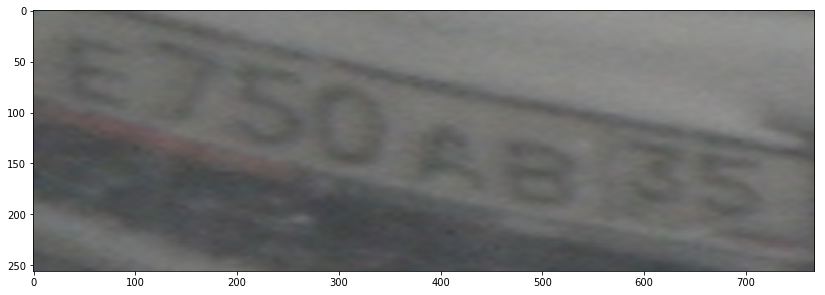

In [25]:
show_sample(val_ocr_dataset[10])

In [26]:
i = -1

B060BB125


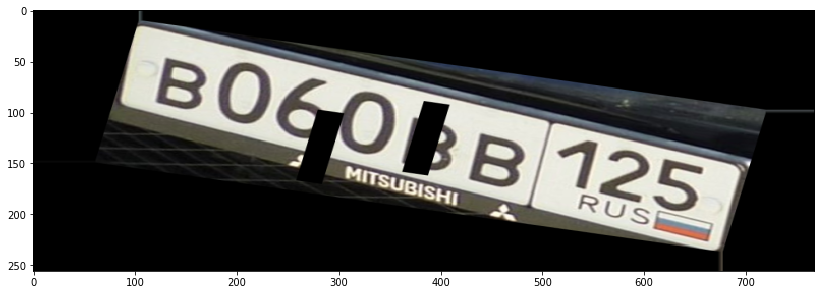

In [27]:
i += 1
show_sample(train_ocr_dataset[i])

H162YP32


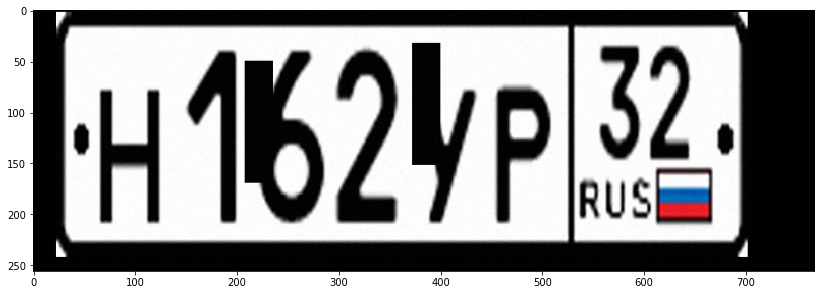

In [28]:
show_sample(generated_ocr_dataset[-1])

# Модель OCR

In [29]:
device = torch.device(DEVICE_NAME) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=1)

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=OUT_LEN+1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        self.pe_weight = torch.randn(1, requires_grad=True).to(device)

    def forward(self, x):
        x = x + self.pe_weight * self.pe[:x.size(0), :]
        return self.dropout(x)

    
class TransformerDecoder(nn.Module):
    def __init__(self, hid_dim, dim_ff, n_heads, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        
        decoder_layers = nn.TransformerDecoderLayer(hid_dim, n_heads, dim_ff, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, n_layers)
        
    def forward(self, input, encoder_outputs, key_padding_mask=None):        
        # input = [src len, batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim]
        
        # [src len, batch size, hid dim]
        outputs = self.transformer_decoder(input, encoder_outputs, tgt_key_padding_mask=key_padding_mask)        
       
        return outputs

In [31]:
class RecognitionModel(nn.Module):
    def __init__(self,
                    input_size=PLATE_SIZE,
                    dropout=0.2,
                    num_classes=len(alphabet)+1,
                    hid_dim=512,
                    dim_ff=512,
                    n_heads=8,
                    n_layers=8):
        super(RecognitionModel, self).__init__()
        self.num_classes = num_classes
        self.hid_dim = hid_dim

        resnet = getattr(models, 'resnet34')(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.num_backbone_features = self.get_block_size(self.backbone)
        
        self.channel_projector = nn.Conv2d(self.num_backbone_features, self.hid_dim, kernel_size=1)
        self.height_projector = nn.Conv2d(input_size[1] // 32, 1, kernel_size=1)
        
        self.pos_encoder = PositionalEncoding(hid_dim, dropout)
        
        self.decoder = TransformerDecoder(hid_dim=self.hid_dim,
                                            dim_ff=dim_ff,
                                            n_heads=n_heads,
                                            n_layers=n_layers,
                                            dropout=dropout)
        
        self.seq_out = nn.Linear(
            in_features=hid_dim,
            out_features=self.num_classes,
            bias=False
        )
        
        # Нечто вроде эмбеддинга токена <CLS> в BERT'е
        self.cls_embedding = torch.randn(self.hid_dim, requires_grad=True).to(device)
        
        self.classifier_out = nn.Linear(
            in_features=hid_dim,
            out_features=1,
            bias=True
        )
        
        self.softmax = nn.Softmax(dim=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, decode=False):
        
        # features = [b, c, h, w]
        features = self.backbone(x)
        
        # features = [b, c, h, w]
        features = self.channel_projector(features)
        
        # features_sequence = [w+1, b, c]
        # Последний "токен" - запрос на предсказание уверенности в корректности картинки
        features_sequence = self.features_to_sequence(features)
        
        # features_sequence = [w+1, b, c]
        features_sequence = self.pos_encoder(features_sequence)
        
        # out_sequence = [w+1, b, c]
        decoder_output = self.decoder(features_sequence, features_sequence)
        
        out_sequence = self.seq_out(decoder_output[:-1,...]) # [seq len, b, out dim]
        
        cls_out = self.classifier_out(decoder_output[-1,...]).squeeze(-1) # [b]

        if not self.training:
            out_sequence = self.softmax(out_sequence)
            cls_out = self.sigmoid(cls_out)
            if decode:
                out_sequence = self.decode(out_sequence)

        return out_sequence, cls_out

    def features_to_sequence(self, features):
        # features = [b, c, h, w]
        b, c, h, w = features.shape
        assert c == self.hid_dim
        features = features.permute(0, 2, 1, 3).contiguous() # [b, h, c, w]
        features = self.height_projector(features) # [b, h'=1, c, w]
        features = features.squeeze(1).permute(2, 0, 1).contiguous() # [w, b, c]
        cls_token = self.cls_embedding.unsqueeze(0).unsqueeze(0) # [w=1, b=1, c]
        cls_token = cls_token.repeat(1, b, 1) # [w=1, b, c]
        assert cls_token.shape == (1, b, c)
        features = torch.cat([features, cls_token], dim=0) # [w+1, b, c]
        assert features.shape == (w+1, b, c)
        return features

    def get_block_size(self, layer):
        return list(layer[-1][-1].children())[-2].weight.size()[0]

    def pred_to_string(self, pred):
        seq = []
        for i in range(len(pred)):
            label = np.argmax(pred[i])
            seq.append(label)
        out = []
        for i in range(len(seq)):
            if len(out) == 0:
                if seq[i] != 0:
                    out.append(seq[i])
            else:
                if seq[i] != 0 and seq[i] != seq[i - 1]:
                    out.append(seq[i])
        out = to_text(out)
        return out

    def decode(self, pred):
        pred = pred.permute(1, 0, 2).cpu().data.numpy()
        outputs = []
        for i in range(len(pred)):
            outputs.append(self.pred_to_string(pred[i]))
        return outputs

In [32]:
@torch.no_grad()
def get_merics(model, iterator, with_tqdm=True):    
    model.eval()
    count, tp, avg_ed = 0, 0, 0
    if with_tqdm:
        iterator = tqdm(iterator, total=len(iterator), leave=True, position=0, desc='batch')
    target_texts, target_labels, pred_texts, pred_scores, edistances = [], [], [], [], []
    for batch in iterator:
        images = batch['image'].to(device)
        target_texts.extend(batch['text'])
        target_labels.extend(batch['is_correct'].cpu().numpy())
        pred_seq, scores = model(images, decode=True)
        pred_texts.extend(pred_seq)
        pred_scores.extend(scores.cpu().numpy())
        edistances.extend([editdistance.eval(pred, target) for (pred, target) in zip(pred_seq, batch['text'])])
    metrics = pd.DataFrame(dict(target_text=target_texts, pred_text=pred_texts,
                            target_label=target_labels, pred_score=pred_scores, edistance=edistances))
    # Если модель отвечает, что это некорреткная картинка, то её ответ - пустая строка
    # и редакционное расстояние от ответа модели до таргета - длина таргета
    metrics['edistance_given_0'] = metrics.target_text.str.len()
    return metrics

In [33]:
def get_best_threshold(metrics, plot=True):
    thresholds = metrics.pred_score.sort_values().unique()
    mean_edistances = []
    for threshold in thresholds:
        pred = metrics.pred_score >= threshold
        edit_distance = np.where(pred, metrics.edistance.values, metrics.edistance_given_0.values)
        mean_edit_distance = edit_distance.mean()
        mean_edistances.append(mean_edit_distance)
    mean_edistances = np.array(mean_edistances)
    if plot:
        plt.plot(thresholds, mean_edistances)
    best_idx = mean_edistances.argmin()
    best_threshold = thresholds[best_idx]
    best_ed = mean_edistances[best_idx]
    best_accuracy = (np.where(metrics.pred_score >= best_threshold, metrics.pred_text, '') == metrics.target_text).mean()
    print(f'Best threshold={best_threshold:.5f} with edit distance={best_ed:.5f} and accuracy={best_accuracy:.5f}')
    return best_threshold, best_ed, best_accuracy

In [34]:
def evaluate(model, iterator, with_tqdm=True):    
    metrics = get_merics(model, iterator, with_tqdm)
    best_threshold, best_ed, best_accuracy = get_best_threshold(metrics, plot=False)
    return best_accuracy, best_ed

In [35]:
from torch.nn.functional import log_softmax

cross_entropy_loss = nn.BCEWithLogitsLoss(reduction='mean')
ctc_loss = nn.CTCLoss(reduction='mean')

def train(model, optimizer, scheduler, train_dataloader, val_dataloader, epochs=10, ctc_weight=1):
    # TODO: try different techniques for fighting overfitting of the trained modelwork
    best_val_ed = float('inf')
    best_val_acc = -1
    for e in range(epochs):
        print('Starting epoch {}/{}.'.format(e + 1, epochs))
        
        model.train()
            
        losses = []
        ce_losses = []
        ctc_losses = []
        train_iter = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True, position=0, desc='batch')
        for j, batch in train_iter:
            optimizer.zero_grad()
            images = batch['image'].to(device)
            is_correct = batch['is_correct']
            seqs = batch['seq']
            seq_lens = batch['seq_len']
#             scores = batch['score'] # Скоры детектора
            ctc_mask = batch['ctc_mask'] # True <=> номер корректен
            
            # seqs_pred = [seq len, b, out dim]
            # scores_pred = [b]
            seqs_pred, scores_pred = model(images)
            seqs_pred = seqs_pred.cpu()
            scores_pred = scores_pred.cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            log_probs = log_probs[:, ctc_mask, :] # Вычисляем CTC-лосс только для семплов, являющихся корректными номерами
            
            ctc = 0
            if ctc_mask.numpy().any():
                seq_lens_pred = torch.Tensor([log_probs.size(0)] * log_probs.size(1)).int()
                ctc = ctc_loss(log_probs, seqs, seq_lens_pred, seq_lens)
            cross_entropy = cross_entropy_loss(scores_pred, is_correct)
            loss = ctc_weight * ctc + cross_entropy
            
            loss.backward()
            losses.append(loss.item())
            ce_losses.append(cross_entropy.item())
            ctc_losses.append(ctc if type(ctc) is int else ctc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer.step()
            
            if scheduler is not None:
                scheduler.step()
            
        print('Epoch finished! Loss: {:.5f}\tCTC Loss: {:.5f}\tCE Loss: {:.5f}'.format(
        np.mean(losses), np.mean(ctc_losses), np.mean(ce_losses)))

        model.eval()
        acc_val, ed_val = evaluate(model, val_dataloader)
#         if scheduler is not None:
#             scheduler.step(ed_val)

        if ed_val < best_val_ed:
            best_val_ed = ed_val
            best_val_acc = acc_val
            torch.save(model.state_dict(), f'models/{MODEL_NAME}.pth')
            print('Valid acc: {:.5f}, valid ed: {:.5f} (best)'.format(acc_val, ed_val))
        else:
            print('Valid acc: {:.5f}, valid ed: {:.5f} (best {:.5f}, {:.5f})'.format(
                acc_val, ed_val, best_val_acc, best_val_ed))
    print('Best valid acc: {:.5f}, best val ed: {:.5f}'.format(best_val_acc, best_val_ed))

In [36]:
model = RecognitionModel()
model.to(device);

In [37]:
with open(f'models/{CHECKPOINT_MODEL_NAME}.pth', "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [38]:
epoch_len = len(train_ocr_loader)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, amsgrad=True, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4*epoch_len, eta_min=1e-6, last_epoch=-1)

In [39]:
train(model, optimizer, scheduler, train_ocr_loader, val_ocr_loader, epochs=50, ctc_weight=2)

Starting epoch 1/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.41375	CTC Loss: 0.17210	CE Loss: 0.06955


batch: 100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Best threshold=0.26681 with edit distance=0.37961 and accuracy=0.90660
Valid acc: 0.90660, valid ed: 0.37961 (best)
Starting epoch 2/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.30251	CTC Loss: 0.12042	CE Loss: 0.06167


batch: 100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Best threshold=0.56221 with edit distance=0.36932 and accuracy=0.92031
Valid acc: 0.92031, valid ed: 0.36932 (best)
Starting epoch 3/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.25047	CTC Loss: 0.09849	CE Loss: 0.05350


batch: 100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Best threshold=0.28488 with edit distance=0.34276 and accuracy=0.92716
Valid acc: 0.92716, valid ed: 0.34276 (best)
Starting epoch 4/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.22594	CTC Loss: 0.08881	CE Loss: 0.04831


batch: 100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Best threshold=0.16245 with edit distance=0.33419 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.33419 (best)
Starting epoch 5/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.22168	CTC Loss: 0.08711	CE Loss: 0.04746


batch: 100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Best threshold=0.33756 with edit distance=0.33333 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.33333 (best)
Starting epoch 6/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23142	CTC Loss: 0.09139	CE Loss: 0.04864


batch: 100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Best threshold=0.18858 with edit distance=0.32562 and accuracy=0.92288
Valid acc: 0.92288, valid ed: 0.32562 (best)
Starting epoch 7/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.25937	CTC Loss: 0.10221	CE Loss: 0.05495


batch: 100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Best threshold=0.50474 with edit distance=0.36332 and accuracy=0.91088
Valid acc: 0.91088, valid ed: 0.36332 (best 0.92288, 0.32562)
Starting epoch 8/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.32869	CTC Loss: 0.13300	CE Loss: 0.06269


batch: 100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Best threshold=0.23311 with edit distance=0.37704 and accuracy=0.90917
Valid acc: 0.90917, valid ed: 0.37704 (best 0.92288, 0.32562)
Starting epoch 9/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.33455	CTC Loss: 0.13532	CE Loss: 0.06391


batch: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Best threshold=0.04270 with edit distance=0.34704 and accuracy=0.91517
Valid acc: 0.91517, valid ed: 0.34704 (best 0.92288, 0.32562)
Starting epoch 10/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.27006	CTC Loss: 0.10600	CE Loss: 0.05807


batch: 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Best threshold=0.29905 with edit distance=0.32819 and accuracy=0.91945
Valid acc: 0.91945, valid ed: 0.32819 (best 0.92288, 0.32562)
Starting epoch 11/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23456	CTC Loss: 0.09205	CE Loss: 0.05045


batch: 100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Best threshold=0.17074 with edit distance=0.32048 and accuracy=0.92716
Valid acc: 0.92716, valid ed: 0.32048 (best)
Starting epoch 12/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.21966	CTC Loss: 0.08705	CE Loss: 0.04556


batch: 100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Best threshold=0.23154 with edit distance=0.32219 and accuracy=0.92631
Valid acc: 0.92631, valid ed: 0.32219 (best 0.92716, 0.32048)
Starting epoch 13/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.21898	CTC Loss: 0.08679	CE Loss: 0.04541


batch: 100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Best threshold=0.22461 with edit distance=0.31534 and accuracy=0.92631
Valid acc: 0.92631, valid ed: 0.31534 (best)
Starting epoch 14/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.22761	CTC Loss: 0.09012	CE Loss: 0.04737


batch: 100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Best threshold=0.55679 with edit distance=0.33590 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.33590 (best 0.92631, 0.31534)
Starting epoch 15/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23999	CTC Loss: 0.09379	CE Loss: 0.05240


batch: 100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Best threshold=0.08618 with edit distance=0.36418 and accuracy=0.91602
Valid acc: 0.91602, valid ed: 0.36418 (best 0.92631, 0.31534)
Starting epoch 16/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.27594	CTC Loss: 0.10990	CE Loss: 0.05615


batch: 100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Best threshold=0.50717 with edit distance=0.33847 and accuracy=0.91945
Valid acc: 0.91945, valid ed: 0.33847 (best 0.92631, 0.31534)
Starting epoch 17/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.30490	CTC Loss: 0.12413	CE Loss: 0.05665


batch: 100%|██████████| 37/37 [00:10<00:00,  3.48it/s]


Best threshold=0.26840 with edit distance=0.35476 and accuracy=0.91859
Valid acc: 0.91859, valid ed: 0.35476 (best 0.92631, 0.31534)
Starting epoch 18/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.26736	CTC Loss: 0.10701	CE Loss: 0.05335


batch: 100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Best threshold=0.18123 with edit distance=0.32905 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.32905 (best 0.92631, 0.31534)
Starting epoch 19/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23513	CTC Loss: 0.09476	CE Loss: 0.04561


batch: 100%|██████████| 37/37 [00:10<00:00,  3.54it/s]


Best threshold=0.32598 with edit distance=0.32905 and accuracy=0.93059
Valid acc: 0.93059, valid ed: 0.32905 (best 0.92631, 0.31534)
Starting epoch 20/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.21612	CTC Loss: 0.08677	CE Loss: 0.04257


batch: 100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Best threshold=0.18247 with edit distance=0.34019 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.34019 (best 0.92631, 0.31534)
Starting epoch 21/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20762	CTC Loss: 0.08313	CE Loss: 0.04135


batch: 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Best threshold=0.10561 with edit distance=0.30077 and accuracy=0.93402
Valid acc: 0.93402, valid ed: 0.30077 (best)
Starting epoch 22/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20415	CTC Loss: 0.08060	CE Loss: 0.04295


batch: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


Best threshold=0.12277 with edit distance=0.32991 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.32991 (best 0.93402, 0.30077)
Starting epoch 23/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23298	CTC Loss: 0.09228	CE Loss: 0.04843


batch: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


Best threshold=0.17703 with edit distance=0.32734 and accuracy=0.92545
Valid acc: 0.92545, valid ed: 0.32734 (best 0.93402, 0.30077)
Starting epoch 24/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.25595	CTC Loss: 0.10126	CE Loss: 0.05343


batch: 100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Best threshold=0.29136 with edit distance=0.34105 and accuracy=0.91345
Valid acc: 0.91345, valid ed: 0.34105 (best 0.93402, 0.30077)
Starting epoch 25/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.28828	CTC Loss: 0.11595	CE Loss: 0.05638


batch: 100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


Best threshold=0.23001 with edit distance=0.34790 and accuracy=0.91688
Valid acc: 0.91688, valid ed: 0.34790 (best 0.93402, 0.30077)
Starting epoch 26/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.27442	CTC Loss: 0.11146	CE Loss: 0.05149


batch: 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Best threshold=0.20565 with edit distance=0.34790 and accuracy=0.92631
Valid acc: 0.92631, valid ed: 0.34790 (best 0.93402, 0.30077)
Starting epoch 27/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23778	CTC Loss: 0.09589	CE Loss: 0.04601


batch: 100%|██████████| 37/37 [00:10<00:00,  3.55it/s]


Best threshold=0.18807 with edit distance=0.32391 and accuracy=0.92973
Valid acc: 0.92973, valid ed: 0.32391 (best 0.93402, 0.30077)
Starting epoch 28/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20881	CTC Loss: 0.08350	CE Loss: 0.04181


batch: 100%|██████████| 37/37 [00:10<00:00,  3.53it/s]


Best threshold=0.20977 with edit distance=0.32305 and accuracy=0.93059
Valid acc: 0.93059, valid ed: 0.32305 (best 0.93402, 0.30077)
Starting epoch 29/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.21115	CTC Loss: 0.08511	CE Loss: 0.04092


batch: 100%|██████████| 37/37 [00:10<00:00,  3.50it/s]


Best threshold=0.09087 with edit distance=0.32562 and accuracy=0.92888
Valid acc: 0.92888, valid ed: 0.32562 (best 0.93402, 0.30077)
Starting epoch 30/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20233	CTC Loss: 0.08011	CE Loss: 0.04210


batch: 100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Best threshold=0.12847 with edit distance=0.33676 and accuracy=0.92802
Valid acc: 0.92802, valid ed: 0.33676 (best 0.93402, 0.30077)
Starting epoch 31/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.21620	CTC Loss: 0.08490	CE Loss: 0.04639


batch: 100%|██████████| 37/37 [00:10<00:00,  3.62it/s]


Best threshold=0.20738 with edit distance=0.34790 and accuracy=0.92545
Valid acc: 0.92545, valid ed: 0.34790 (best 0.93402, 0.30077)
Starting epoch 32/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.28595	CTC Loss: 0.11663	CE Loss: 0.05269


batch: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Best threshold=0.13029 with edit distance=0.34876 and accuracy=0.90488
Valid acc: 0.90488, valid ed: 0.34876 (best 0.93402, 0.30077)
Starting epoch 33/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.28846	CTC Loss: 0.11705	CE Loss: 0.05435


batch: 100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Best threshold=0.68031 with edit distance=0.32134 and accuracy=0.92202
Valid acc: 0.92202, valid ed: 0.32134 (best 0.93402, 0.30077)
Starting epoch 34/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.24219	CTC Loss: 0.09696	CE Loss: 0.04826


batch: 100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Best threshold=0.29066 with edit distance=0.33248 and accuracy=0.92117
Valid acc: 0.92117, valid ed: 0.33248 (best 0.93402, 0.30077)
Starting epoch 35/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.22251	CTC Loss: 0.08981	CE Loss: 0.04289


batch: 100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Best threshold=0.39732 with edit distance=0.32391 and accuracy=0.92459
Valid acc: 0.92459, valid ed: 0.32391 (best 0.93402, 0.30077)
Starting epoch 36/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20158	CTC Loss: 0.08220	CE Loss: 0.03718


batch: 100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Best threshold=0.32616 with edit distance=0.32819 and accuracy=0.92374
Valid acc: 0.92374, valid ed: 0.32819 (best 0.93402, 0.30077)
Starting epoch 37/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.19663	CTC Loss: 0.07972	CE Loss: 0.03719


batch: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Best threshold=0.31978 with edit distance=0.33419 and accuracy=0.92288
Valid acc: 0.92288, valid ed: 0.33419 (best 0.93402, 0.30077)
Starting epoch 38/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20475	CTC Loss: 0.08271	CE Loss: 0.03932


batch: 100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Best threshold=0.58500 with edit distance=0.33590 and accuracy=0.92545
Valid acc: 0.92545, valid ed: 0.33590 (best 0.93402, 0.30077)
Starting epoch 39/50.


batch:  36%|███▌      | 530/1480 [05:48<10:22,  1.53it/s]

Failed to load/convert image train/12629.jpg


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.21510	CTC Loss: 0.08608	CE Loss: 0.04294


batch: 100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Best threshold=0.14195 with edit distance=0.34190 and accuracy=0.92031
Valid acc: 0.92031, valid ed: 0.34190 (best 0.93402, 0.30077)
Starting epoch 40/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.25173	CTC Loss: 0.10105	CE Loss: 0.04963


batch: 100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Best threshold=0.47950 with edit distance=0.35390 and accuracy=0.91774
Valid acc: 0.91774, valid ed: 0.35390 (best 0.93402, 0.30077)
Starting epoch 41/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.26131	CTC Loss: 0.10610	CE Loss: 0.04911


batch: 100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Best threshold=0.17565 with edit distance=0.34105 and accuracy=0.91688
Valid acc: 0.91688, valid ed: 0.34105 (best 0.93402, 0.30077)
Starting epoch 42/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23138	CTC Loss: 0.09275	CE Loss: 0.04588


batch: 100%|██████████| 37/37 [00:13<00:00,  2.82it/s]


Best threshold=0.26392 with edit distance=0.34019 and accuracy=0.92545
Valid acc: 0.92545, valid ed: 0.34019 (best 0.93402, 0.30077)
Starting epoch 43/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20303	CTC Loss: 0.08163	CE Loss: 0.03977


batch: 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Best threshold=0.20929 with edit distance=0.32734 and accuracy=0.92716
Valid acc: 0.92716, valid ed: 0.32734 (best 0.93402, 0.30077)
Starting epoch 44/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.18937	CTC Loss: 0.07749	CE Loss: 0.03438


batch: 100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Best threshold=0.13957 with edit distance=0.31105 and accuracy=0.92888
Valid acc: 0.92888, valid ed: 0.31105 (best 0.93402, 0.30077)
Starting epoch 45/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.19459	CTC Loss: 0.08062	CE Loss: 0.03336


batch: 100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Best threshold=0.24770 with edit distance=0.33933 and accuracy=0.92631
Valid acc: 0.92631, valid ed: 0.33933 (best 0.93402, 0.30077)
Starting epoch 46/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20427	CTC Loss: 0.08384	CE Loss: 0.03658


batch: 100%|██████████| 37/37 [00:10<00:00,  3.65it/s]


Best threshold=0.22885 with edit distance=0.35047 and accuracy=0.92374
Valid acc: 0.92374, valid ed: 0.35047 (best 0.93402, 0.30077)
Starting epoch 47/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.20731	CTC Loss: 0.08314	CE Loss: 0.04102


batch: 100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


Best threshold=0.61791 with edit distance=0.32562 and accuracy=0.92888
Valid acc: 0.92888, valid ed: 0.32562 (best 0.93402, 0.30077)
Starting epoch 48/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.23583	CTC Loss: 0.09581	CE Loss: 0.04421


batch: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


Best threshold=0.57453 with edit distance=0.36161 and accuracy=0.92031
Valid acc: 0.92031, valid ed: 0.36161 (best 0.93402, 0.30077)
Starting epoch 49/50.


batch:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch finished! Loss: 0.24023	CTC Loss: 0.09693	CE Loss: 0.04636


batch: 100%|██████████| 37/37 [00:10<00:00,  3.58it/s]


Best threshold=0.21517 with edit distance=0.32476 and accuracy=0.92631
Valid acc: 0.92631, valid ed: 0.32476 (best 0.93402, 0.30077)
Starting epoch 50/50.


batch:   1%|          | 14/1480 [00:12<15:55,  1.53it/s] 

Failed to load/convert image train/14475.jpg


KeyboardInterrupt: 

In [40]:
with open(f'models/{MODEL_NAME}.pth', "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

# Определяем оптимальный порог

In [41]:
metrics = get_merics(model, val_ocr_loader)

batch: 100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Best threshold=0.10561 with edit distance=0.30077 and accuracy=0.93402


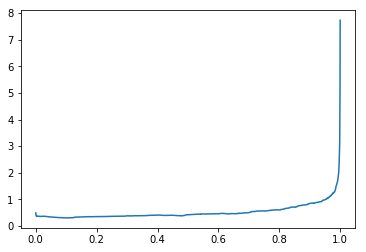

In [42]:
best_threshold, _, _ = get_best_threshold(metrics)

# Submit

In [43]:
with open(test_pred_boxes_file) as rf:
    test_pred_boxes = json.load(rf)
len(test_pred_boxes)

3183

In [44]:
sample_submit = pd.read_csv(os.path.join(data_path, 'submission.csv'))

In [45]:
test_ocr_dataset = OCRDataset(
    test_pred_boxes,
    transforms=val_ocr_transforms
)

In [46]:
test_ocr_loader = DataLoader(
    test_ocr_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn_ocr,
    shuffle=False
)

In [47]:
@torch.no_grad()
def make_submit(model, test_loader, threshold, with_tqdm=True, sample_submit=sample_submit):    
    model.eval()
    
    submit = sample_submit.copy()
    submit.drop('plates_string', axis=1, inplace=True)
    results = {}
    
    if with_tqdm:
        iterator = tqdm(test_loader, total=len(test_loader), leave=True, position=0, desc='batch')
    for batch in iterator:
        fnames = batch['file']
        images = batch['image'].to(device)
        
        pred_seq, scores = model(images, decode=True)       
        for fname, pred_text, score in zip(fnames, pred_seq, scores.cpu().numpy()):
            if score < threshold:
                continue
            if fname in results:
                results[fname] += ' ' + pred_text
            else:
                results[fname] = pred_text
    
    results = [{'file_name': fname, 'plates_string': pred} for (fname, pred) in results.items()]
    results = pd.DataFrame.from_records(results)
    submit = submit.merge(results, on='file_name', how='left')
    submit.plates_string.fillna('', inplace=True)
    return submit

In [48]:
submit = make_submit(model, test_ocr_loader, best_threshold)

batch: 100%|██████████| 116/116 [00:27<00:00,  6.78it/s]


In [49]:
submit.head()

,file_name,plates_string
0,test/0.jpg,O195KC96
1,test/1.jpg,O001OO24 O005OO24
2,test/2.jpg,H030MB33
3,test/3.jpg,A852TO21 C139AP96
4,test/4.bmp,B955ET35


In [50]:
submit.to_csv(f'submits/submit_{MODEL_NAME}.csv', index=False)

# Визуализация предсказаний

In [51]:
test_boxes = {pred['file']: pred['boxes'] for pred in test_pred_boxes}
test_detector_scores = {pred['file']: pred['scores'] for pred in test_pred_boxes}

In [52]:
def show_sample(index, df, boxes=test_boxes, detector_scores=test_detector_scores, data_path=data_path):
    fig = plt.figure(figsize=(14,10))
    fname = df.at[index, 'file']
    pred_text = df.at[index, 'plate']
    fpath = os.path.join(data_path, fname)
    print(f'File: {fname}')
    print(f'Predicted: {pred_text}')
    print(f'Detector scores: {detector_scores[fname]}')
    pred_boxes = boxes[fname]
    img = cv2.imread(fpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box in pred_boxes:
        x1, y1, x2, y2 = box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(PALETTE[0]) * 255, 2)
    plt.imshow(img)

In [53]:
plates = pd.DataFrame.from_records([dict(file=file, plate=plate)
                                for (file, plates) in zip(submit.file_name, submit.plates_string.str.split())
                                for plate in plates])

In [54]:
plates['plate_len'] = plates.plate.str.len()

In [55]:
plates.plate_len.value_counts()

8     2611
9      895
7        7
10       2
11       1
Name: plate_len, dtype: int64

In [59]:
plates[plates.plate_len == 10]

,file,plate,plate_len
1672,test/1516.jpg,P905KT1977,10
2544,test/2303.jpg,P272TO1235,10


File: test/2303.jpg
Predicted: P272TO1235
Detector scores: [0.6907026767730713, 0.7359238266944885]


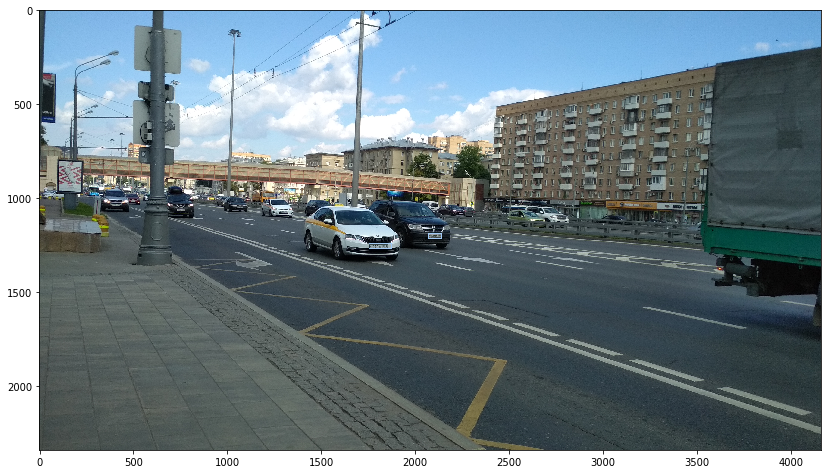

In [61]:
show_sample(2544, plates)

In [58]:
submit.iloc[815]

file_name        test/815.jpg
plates_string        M350BO46
Name: 815, dtype: object